# Выявление аномалий во временных рядах

Импорт библиотек

In [40]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
sns.set(style="whitegrid")
plt.rc('figure',figsize=(12,3))
plt.rc('font',size=15)

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)


In [41]:
try:
    import adtk
except:
    !pip install adtk
finally:
    import adtk

In [42]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

Загружаем климатический датасет, дропаем лишние колонки, переименовываем наблюдаемую колонку meantemp в value для удобства 

In [43]:
path_ts1 = 'DailyDelhiClimateTrain.csv'
path_ts2 = 'DailyDelhiClimateTest.csv'
df1 = pd.read_csv(path_ts1, parse_dates=['date'], index_col="date")
df2 = pd.read_csv(path_ts2, parse_dates=['date'], index_col="date")
df = pd.concat([df1, df2])
df_unique = df[~df.index.duplicated()].copy() 
# df = pd.read_csv(path_ts)
# df=df.fillna(df.mean())
data = df_unique.drop(['humidity', 'wind_speed', 'meanpressure'], axis=1)
data.rename(columns = {'meantemp':'value'}, inplace = True )
data.head()

,value
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


Зададим функцию для визуализации. Функция будет принимать на вход массив данных в формате `DataFram`, где индексы - это временные метки.
Также в функцию могут быть заданы аномалии в виде `DataFram`, в котором метки `True` соответствуют аномалиям, а остальные метки имеют значения `False`.



In [44]:
def plot_an(data,  anomalies =None, column = 'value', figsize = (12,3), ax=None,
             fill_an = False, score_column=None, anomaly_column = None):
    
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    
    y = data[column].values.reshape(-1, 1)
    ax.plot(data.index, y, c='k', label = column, zorder=10)    
       
    if  anomalies is not None:   
        if anomaly_column is None: 
            anomaly_column = column
        
        anomalies = pd.DataFrame(anomalies, columns=[anomaly_column, score_column])

        idxs = pd.DataFrame(anomalies).loc[anomalies[anomaly_column] ==True].index
        an_data = pd.DataFrame(data.loc[idxs,column] )

        y_an = an_data.values.reshape(-1, 1)
        
        if fill_an:
            idx = data.index
            points = [{'fp':idx[i-1], 'lp':idx[i+1]} for i in range(1,len(idx)-1) if anomalies.iloc[i].value==True]
            points = pd.DataFrame(points)
            [ax.axvspan(points.fp[i], points.lp[i], alpha=.5, color='green', zorder=2) for i in range(len(points))];
        
        an_size = 20
        if score_column is not None:
            score_ = anomalies.loc[anomalies[score_column] !=0,score_column].values.squeeze()
#             t      = anomalies.loc[anomalies[score_column] !=0,score_column].index
            an_size = 40*np.abs(score_)#20*np.abs(score_- score_.mean())/score_.std()

        ax.scatter(an_data.index, y_an, marker='o', s=an_size, color = 'red', label = 'Anomaly', zorder=100 )
        #             ax.plot(an_data.index, y_an, marker='.', markersize=8, linewidth=0)
    l = plt.legend()
    l.set_zorder(2000)  # put the legend on top

    return ax
            
    

Построим визуализацию

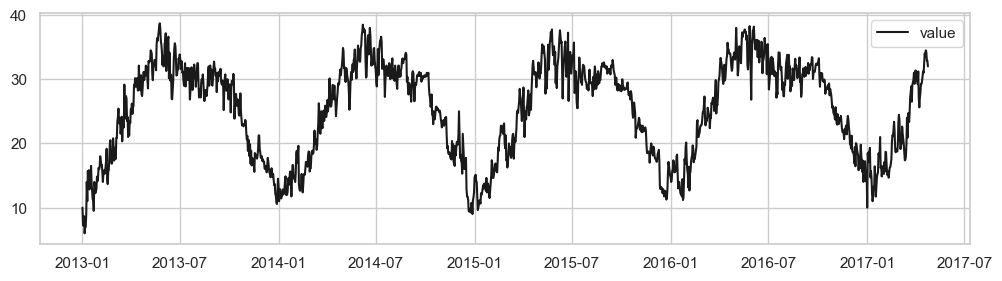

In [45]:
plot_an(data);

## Поиск аномалий на основе правил 

Для начала попробуем найти глобальные аномалии, выставив __пороговые значения__ при помощи функции `ThresholdAD`.

>Отметим, что в `adtk` есть реализация визуализации. Однако, она устарела и несовместима с последними версиями остальных библиотек.

<Axes: >

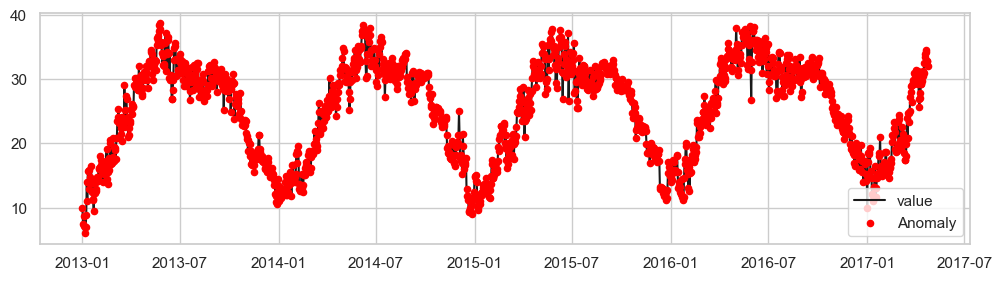

In [46]:
from adtk.detector import ThresholdAD
threshold_val = ThresholdAD(high=27000, low=1000)
anomalies = threshold_val.detect(data.value)
plot_an(data, anomalies)

Результат малоинформативный - аномалиями признаны все экстремумы

Перед тем, как проводить выявление аномалий, ВР может быть номализован, например при помощи `z-score`.

<Axes: >

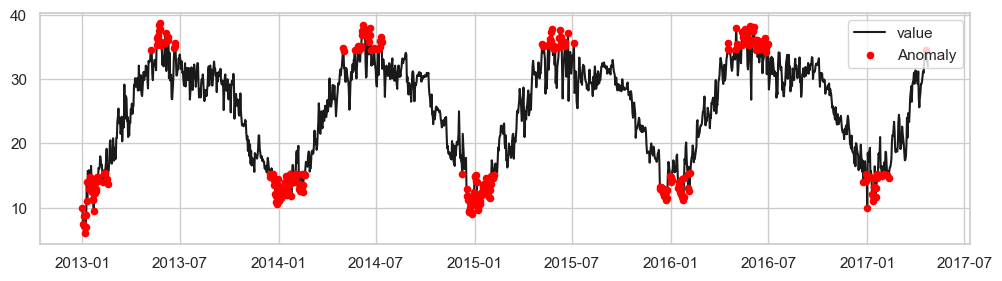

In [47]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=0.25)
anomalies = iqr_ad.fit_detect(data)
anomalies = anomalies.squeeze()
plot_an(data, anomalies)

Попробуем почти по аналогии с порогом осуществить поиск глобальнеых аномалий как значений, не попадающих в __диапазон квантилей__. Выбирем за норму $1$ и $99$ квантили. Для этого зададим объект `QuantileAD`. Данный детектор относится к тому же классу что и `IRQ`, однако с иным методом регулирования порога аномалий.

<Axes: >

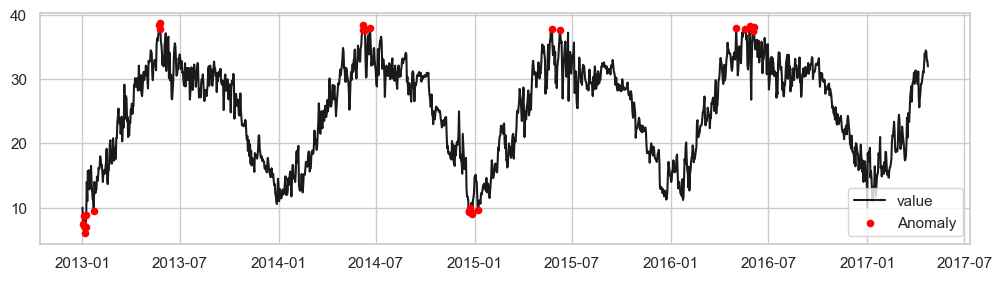

In [48]:
from adtk.detector import QuantileAD

quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(data)

plot_an(data, anomalies)
# plhuetaot(data, anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker");

<Axes: >

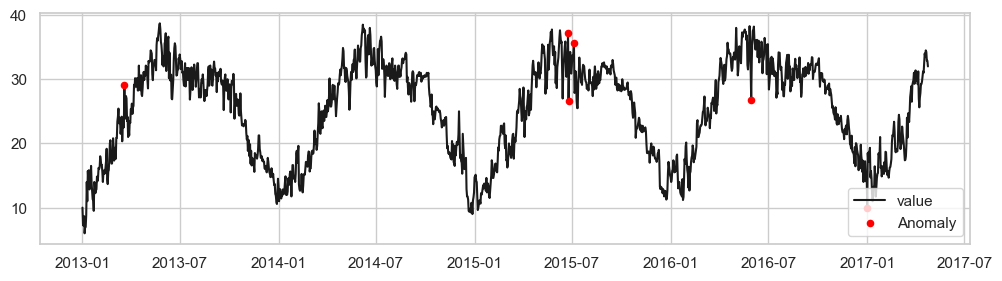

In [64]:
from adtk.detector import GeneralizedESDTestAD
from statsmodels.tsa.seasonal import STL

res = STL(data.values.squeeze(), period = 2).fit()
residuals = pd.DataFrame(res.resid, index = data.index, columns=['value'])

esd_ad = GeneralizedESDTestAD(alpha=0.1)

anomalies = esd_ad.fit_detect(residuals)
# anomalies
plot_an(data, anomalies)

Сомнительный результат

<Axes: >

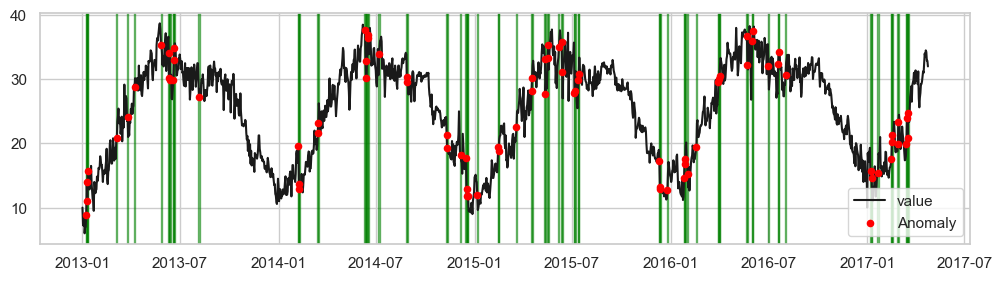

In [70]:
from adtk.detector import LevelShiftAD
level_shift_ad = LevelShiftAD(c=1, side='both', window=4)
anomalies = level_shift_ad.fit_detect(data)
plot_an(data, anomalies, fill_an=True )

Более предсказуемый результат

<Axes: >

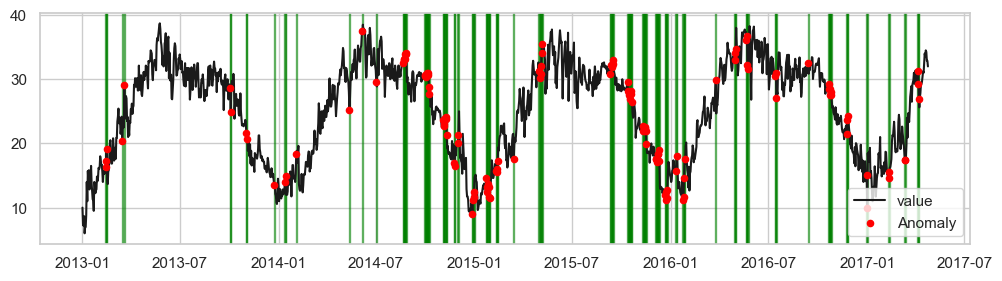

In [77]:
from adtk.detector import VolatilityShiftAD
volatility_shift_ad = VolatilityShiftAD(c=1.0, side='positive', window=10)
anomalies = volatility_shift_ad.fit_detect(data)
plot_an(data, anomalies, fill_an=True)

<Axes: >

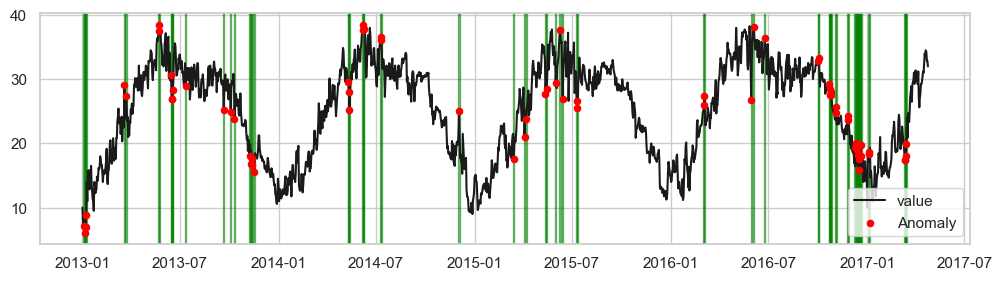

In [78]:
from adtk.detector import SeasonalAD
seasonal_vol = SeasonalAD(c=1.0, side="both")
anomalies = seasonal_vol.fit_detect(data.value)
anomalies.value_counts()

plot_an(data, anomalies, fill_an=True)

Лучший вариант из рассмотренных

### Преобразования данных в `ADTK`

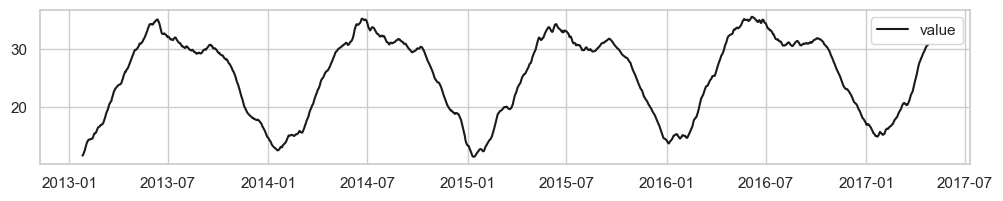

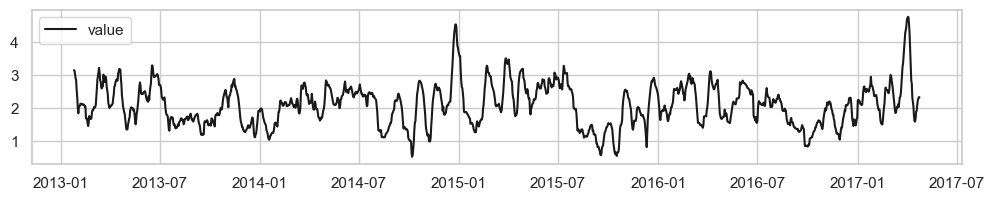

In [53]:
from adtk.transformer import RollingAggregate

data_t = RollingAggregate(agg='mean', window=25).transform(data)
plot_an(data_t, figsize=(12,2));
data_t = RollingAggregate(agg='std', window=25).transform(data)
plot_an(data_t, figsize=(12,2));

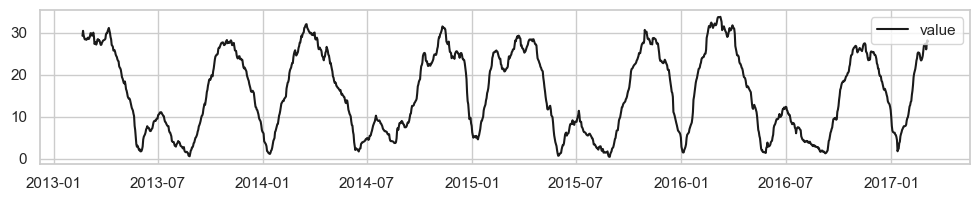

In [54]:
from adtk.transformer import DoubleRollingAggregate
data_t = DoubleRollingAggregate(
    agg="quantile",
    agg_params={"q": [0.1, 0.5, 0.9]},
    window=50).transform(data)
plot_an(data_t,  figsize=(12,2));

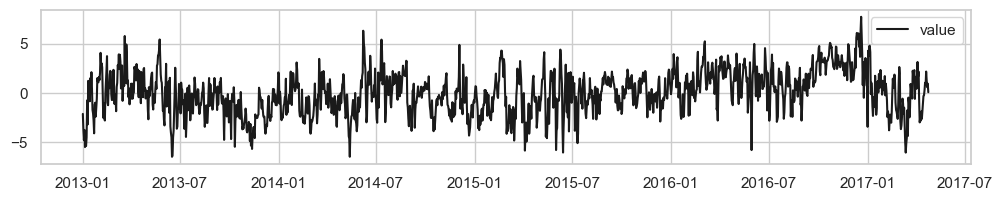

In [79]:
from adtk.transformer import ClassicSeasonalDecomposition
data_t = ClassicSeasonalDecomposition().fit_transform(data)
plot_an(data_t,  figsize=(12,2));

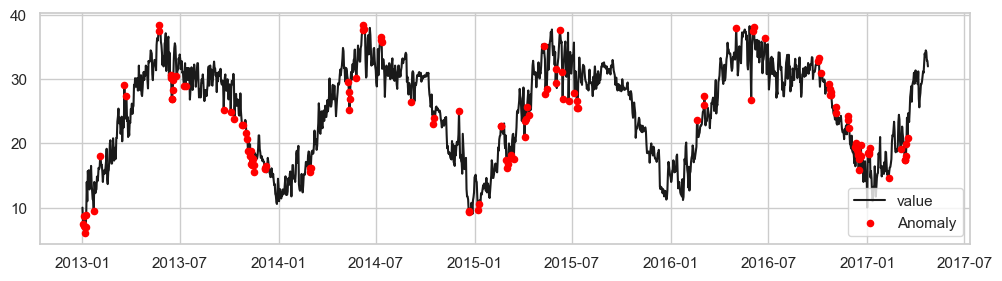

In [87]:
from adtk.pipe import Pipeline
steps = [
    ("deseasonal", ClassicSeasonalDecomposition()),
    ("quantile_ad", QuantileAD(high=0.968, low=0.051))
]
pipeline = Pipeline(steps)
anomalies = pipeline.fit_detect(data)
plot_an(data, anomalies, fill_an=False); 

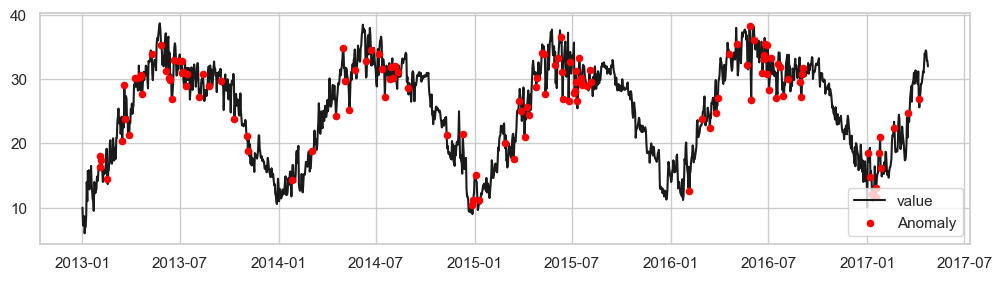

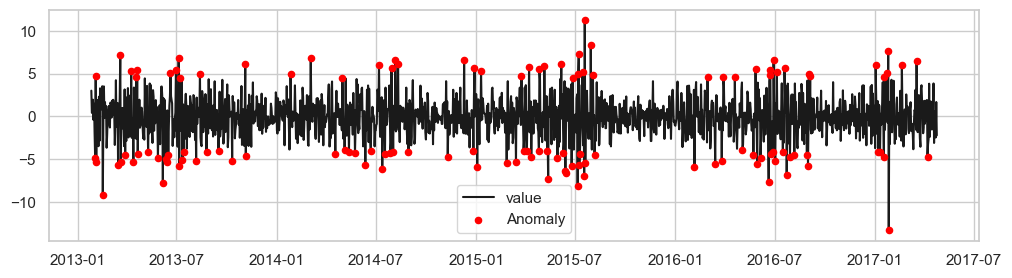

In [88]:
quantile_ad = QuantileAD(high=0.968, low=0.051)
anomalies = quantile_ad.fit_detect(data.value.diff(1).diff(24))
plot_an(data, anomalies);
plot_an(pd.DataFrame(data.value.diff(1).diff(24)).dropna(), anomalies);

Результат существенно улучшился

## Методы из `sklearn`

In [89]:
y = data.value.values.reshape(-1, 1)

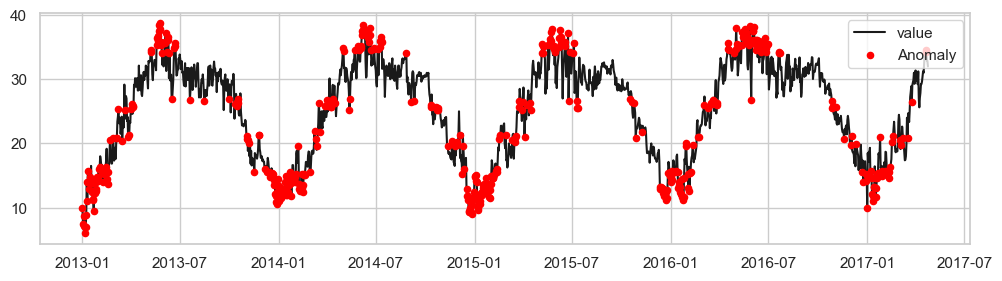

In [94]:
from sklearn.ensemble import IsolationForest

outliers_fraction = 0.3

model =  IsolationForest(contamination=outliers_fraction)
data['anomaly'] = model.fit_predict(y)
an = pd.DataFrame(data['anomaly']==-1).rename(columns={'anomaly':'value'})

plot_an(data, an);

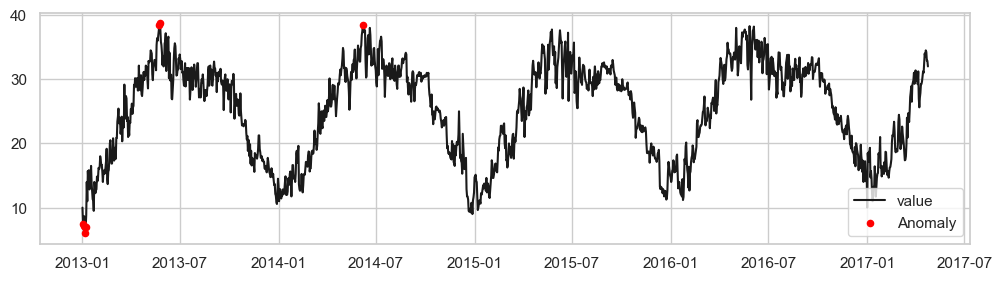

In [95]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(novelty=True)
model.fit(y)
data['anomaly'] = model.predict(y)
an = pd.DataFrame(data['anomaly']==-1).rename(columns={'anomaly':'value'})

plot_an(data, an);

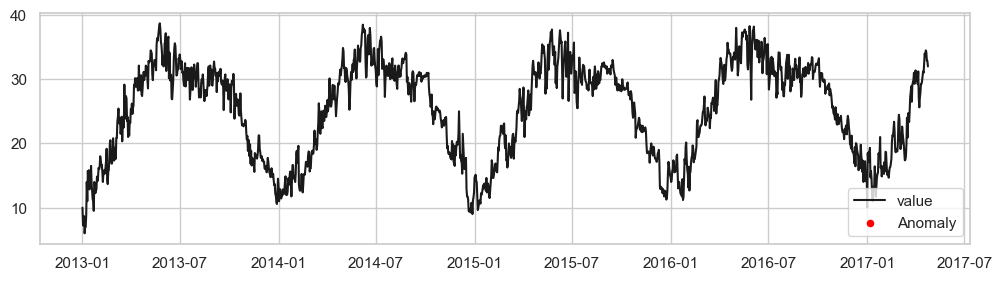

In [101]:
from sklearn.cluster import DBSCAN, KMeans
model=DBSCAN(eps = 100.)
# model = KMeans(n_clusters=10)
model.fit(y)
data['anomaly'] = model.fit_predict(y)
an = pd.DataFrame(data['anomaly']==-1).rename(columns={'anomaly':'value'})
plot_an(data, an);

Эти методы аномалии не видят (что не исключено)

## Выявление аномалий методом предсказаний 

In [102]:
t = pd.DataFrame()
t['ds'] = data.index
t['y'] = data['value'].values

In [103]:
from prophet import Prophet

In [104]:
interval_width = 0.95 
changepoint_range = 0.8
    
m = Prophet(daily_seasonality  = False, 
            yearly_seasonality = False, 
            weekly_seasonality = True,
            seasonality_mode = 'additive', 
            interval_width = interval_width,
            changepoint_range = changepoint_range)

m = m.fit(t)
pred = m.predict(t)

pred['y'] = t['y'].reset_index(drop = True)

pred.head(1)

15:21:35 - cmdstanpy - INFO - Chain [1] start processing
15:21:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2013-01-01,22.505311,8.269066,36.225251,22.505311,22.505311,-0.003671,-0.003671,-0.003671,-0.003671,-0.003671,-0.003671,0.0,0.0,0.0,22.501641,10.0


In [105]:
pred = pred[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'y']].copy()
pred['anomaly'] = 0 #False
pred.loc[pred['y'] > pred['yhat_upper'], 'anomaly'] = 1 #True
pred.loc[pred['y'] < pred['yhat_lower'], 'anomaly'] = -1 #True
pred.index = pred['ds']
pred.head(1)

,ds,trend,yhat,yhat_lower,yhat_upper,y,anomaly
ds,,,,,,,
2013-01-01,2013-01-01,22.505311,22.501641,8.269066,36.225251,10.0,0


In [106]:
pred['score'] = 0
pred.loc[pred['anomaly'] ==1, 'score'] = (pred['y'] - pred['yhat_upper'])/pred['y']
pred.loc[pred['anomaly'] ==-1, 'score'] = (pred['yhat_lower'] - pred['y'])/pred['y']
pred.loc[pred['anomaly'] ==-1, 'anomaly'] = 1
pred.head(1)

,ds,trend,yhat,yhat_lower,yhat_upper,y,anomaly,score
ds,,,,,,,,
2013-01-01,2013-01-01,22.505311,22.501641,8.269066,36.225251,10.0,0,0.0


Визуализируем результат.

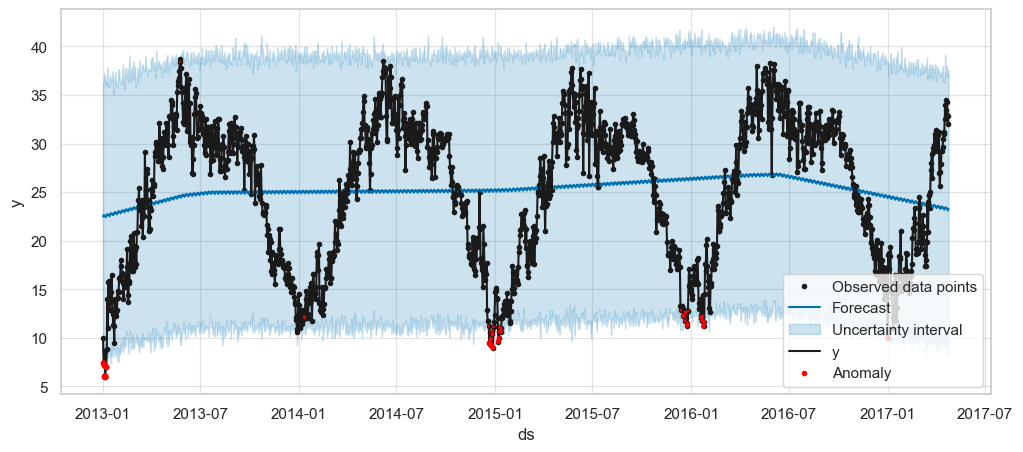

In [107]:
anomaly = pred[['anomaly','score']]


fig, ax = plt.subplots(figsize=(12,5))
m.plot(pred, ax = ax);
plot_an(pred, anomaly, column='y', ax = ax, anomaly_column='anomaly', score_column='score');

## Выявление аномалий методом восстоновления ряда.

In [108]:
%pip install dsatools
%pip install pyod
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



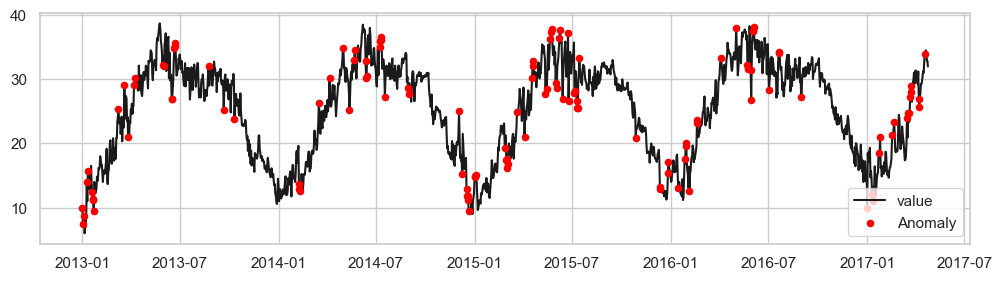

In [109]:
import dsatools.utilits as ut
from sklearn.decomposition import PCA, KernelPCA

m = ut.lags_matrix(y.squeeze(), lags = 24)

clf = PCA(n_components=2,)
X_new = clf.fit_transform(m)
X_rec = clf.inverse_transform(X_new)
score = X_rec.T[0,:y.size]-y.squeeze()

def score2IRQ(data,score, c= 1.0):
    score = pd.DataFrame(score, columns=['value'], index = data.index)
    iqr_ad = InterQuartileRangeAD(c=c)
    anomalies = iqr_ad.fit_detect(score)
    anomalies = anomalies.squeeze()
    plot_an(data, anomalies)

score2IRQ(data,score, c=0.9)    

Результат выглядит субъективно лучшим из рассмотренных

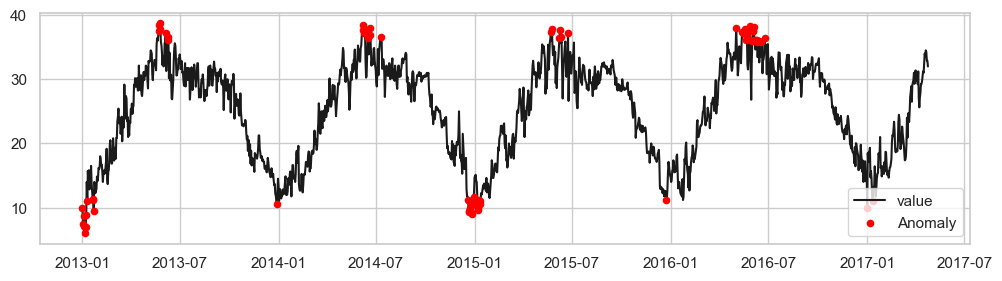

In [113]:
clf = KernelPCA(n_components=2, kernel='rbf', gamma=0.01, degree=3, coef0=1,fit_inverse_transform=True)
X_rec = clf.inverse_transform(clf.fit_transform(m))
score = X_rec.T[0,:y.size]-y.squeeze()

score2IRQ(data,score, c=0.9)   

Подбор коэффициента ядерного преобразования gamma позволяет лишь выделять сезонные экстремумы

Импорт модуля mean_squared_error победить, к сожалению, так и не удалось

In [114]:
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder

clf = AutoEncoder(hidden_neurons =[24,125, 256, 125, 24], verbose=-1)
clf.fit(m);

ImportError: cannot import name 'mean_squared_error' from 'tensorflow.keras.losses' (C:\Users\Killroy\AppData\Roaming\Python\Python311\site-packages\keras\_tf_keras\keras\losses\__init__.py)